In [15]:
import data_cleaning
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn 
import sequential_model
from tqdm import tqdm

In [19]:
data_imgs = np.load('../Kanji-recognizer/data/kkanj-imgs.npz')
data_labels = np.load('../Kanji-recognizer/data/kkanji-labels.npz')

imgs = data_imgs['arr_0']
labels = data_labels['arr_0']

output_folder = 'output_images'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)



print(len(imgs))

filtered_labels, filtered_imgs = data_cleaning.remove_min_occurences(labels, imgs)
filtered_labels, filtered_imgs = data_cleaning.remove_by_contours2(filtered_labels, filtered_imgs)

# filtered_imgs = sequential_model.gy_to_bw(filtered_imgs)


print(len(filtered_labels))
print(filtered_imgs)

X = filtered_imgs
Z = filtered_labels


140424
937
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 32, 157, 178, ...,   0,   0,   0],
       [  4,  38,  86, ...,   0,   0,   0],
       [  0,   1,   7, ...,   0,   0,   0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [198, 242, 253, ...,   0,   0,   0],
       [ 59, 122, 148, ...,   0,   0,   0],
       [  2,  11,  16, ...,

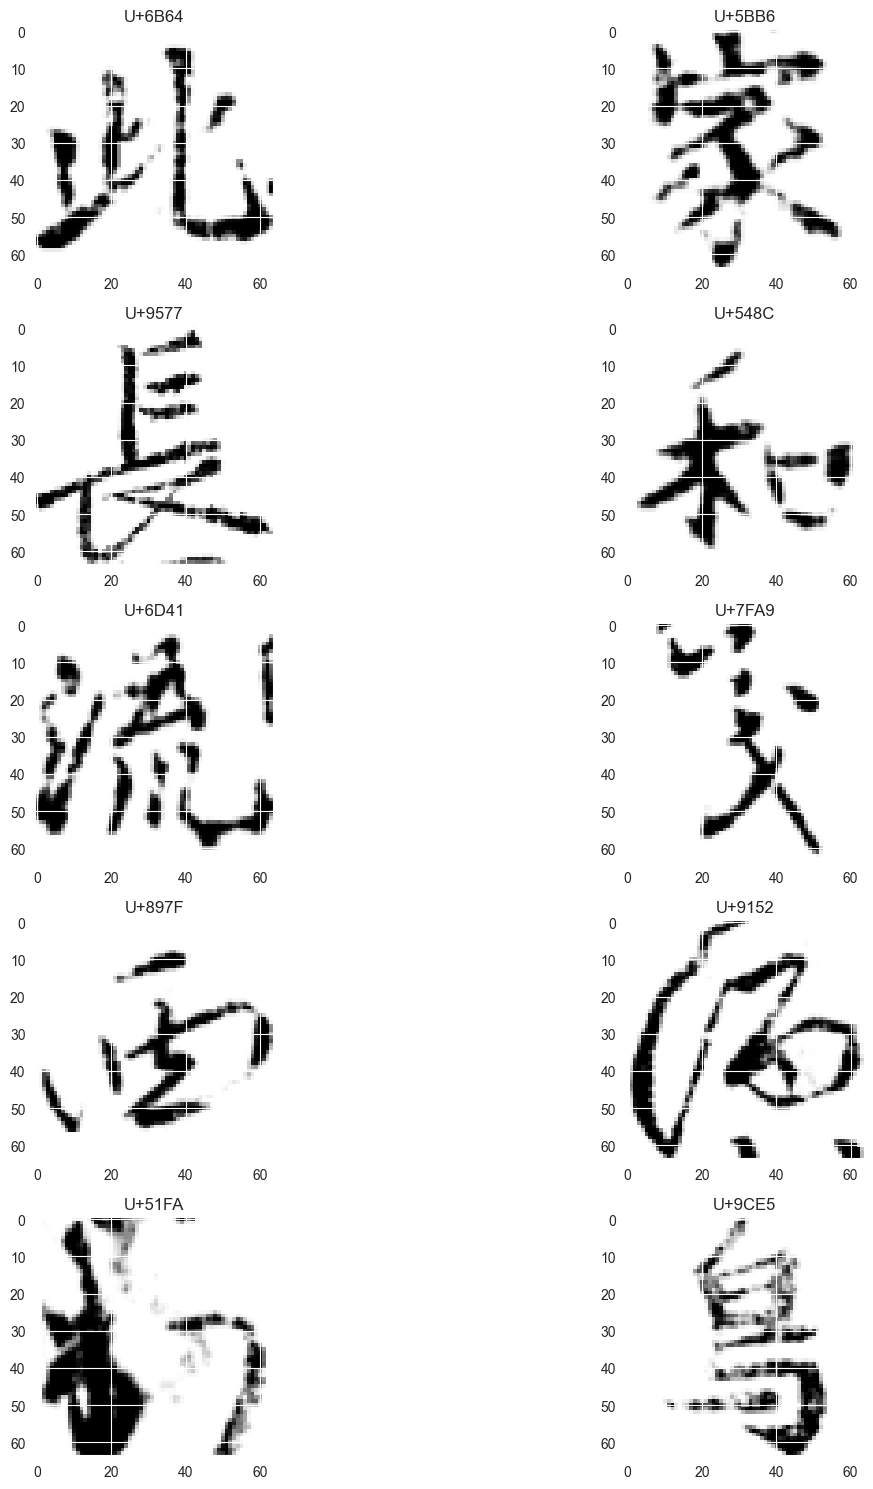

In [20]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l], cmap='Greys')
        ax[i,j].set_title(Z[l])
        
        
plt.tight_layout()

In [6]:
len(np.unique(Z))

309

In [7]:
le=LabelEncoder()


Y=le.fit_transform(Z)


Y=to_categorical(Y,len(np.unique(Z)))


X=np.array(X)


X=X/255


In [8]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [9]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size= (3,3), padding= 'Same', activation='relu', input_shape = (64,64, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(len(np.unique(Z)), activation="softmax"))

2023-05-18 11:41:20.306855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-18 11:41:20.307958: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-18 11:41:20.308431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a475452ce5ea): /proc/driver/nvidia/version does not exist
2023-05-18 11:41:20.315553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

In [10]:
batch_size=200
epochs=3

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.1)

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False,
    vertical_flip=False
)

#datagen.fit(x_train.reshape(10500, 64, 64, 1))

In [12]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        6240      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 96)         0

In [14]:
History = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)

2023-05-18 11:41:26.444172: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1034895360 exceeds 10% of free system memory.


Epoch 1/3
315/315 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.9022

2023-05-18 11:44:18.450462: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 344965120 exceeds 10% of free system memory.


315/315 [==============================] - 182s 558ms/step - loss: 0.5702 - accuracy: 0.9022 - val_loss: 3.2744e-05 - val_accuracy: 1.0000
Epoch 2/3
315/315 [==============================] - 148s 470ms/step - loss: 1.7239e-05 - accuracy: 1.0000 - val_loss: 8.1442e-06 - val_accuracy: 1.0000
Epoch 3/3
315/315 [==============================] - 147s 466ms/step - loss: 5.0262e-06 - accuracy: 1.0000 - val_loss: 3.0798e-06 - val_accuracy: 1.0000


INFO:tensorflow:Assets written to: ../Kanji-recognizer/saved_sequential_model/assets


INFO:tensorflow:Assets written to: ../Kanji-recognizer/saved_sequential_model/assets


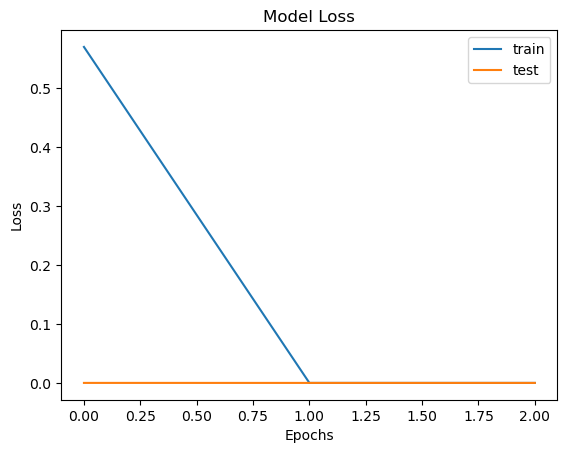

In [15]:
model.save('../Kanji-recognizer/saved_sequential_model')
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [16]:
from matplotlib import pyplot

input_image = ""

results = model.evaluate(x_test, y_test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

print('\n# Generate predictions for 1 sample')

new_image = input_image
new_image2 = tf.expand_dims(x_test[image_number], 0)
predictions = model.predict(new_image)
print('Predictions shape:', predictions.shape)
print('Predictions:', predictions)
predicted_classes = predictions.argmax(axis=-1)
print('Predicted class:', predicted_classes)

pyplot.imshow(new_image, cmap='Greys')
#print(kanji(y_test[image_number]))


  4/658 [..............................] - ETA: 12s - loss: 2.8368e-06 - accuracy: 1.0000

2023-05-18 11:49:29.333165: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 344965120 exceeds 10% of free system memory.


658/658 [==============================] - 11s 17ms/step - loss: 3.0798e-06 - accuracy: 1.0000
Test loss: 3.07984669234429e-06
Test accuracy: 1.0

# Generate predictions for 1 sample


NameError: name 'image_number' is not defined

In [ ]:
import webscraping

print(np.unique(Z)[predicted_classes][0])
print(kanji(np.unique(Z)[predicted_classes][0]))

webscraping.get_meaning(kanji(np.unique(Z)[predicted_classes][0]))

U+4E2D
中

in, 
inside, 
middle, 
mean, 
center

